In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.43.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
klaris_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


In [5]:
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = klaris_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("ogiwemy/klaris", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

In [6]:
dataset[18]

{'input': 'siapa rektor universitas klabat sekarang',
 'output': 'Pdt. Danny I. Rantung, MBA, PhD ',
 'instruction': 'Jelaskan rektor universitas klabat',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nJelaskan rektor universitas klabat\n\n### Input:\nsiapa rektor universitas klabat sekarang\n\n### Response:\nPdt. Danny I. Rantung, MBA, PhD <|end_of_text|>'}

In [7]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/19 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 19 | Num Epochs = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.221500
2,2.360500
3,2.630300
4,2.289300
5,1.753300
6,1.668400
7,1.625400
8,1.332100
9,1.065600
10,1.048700


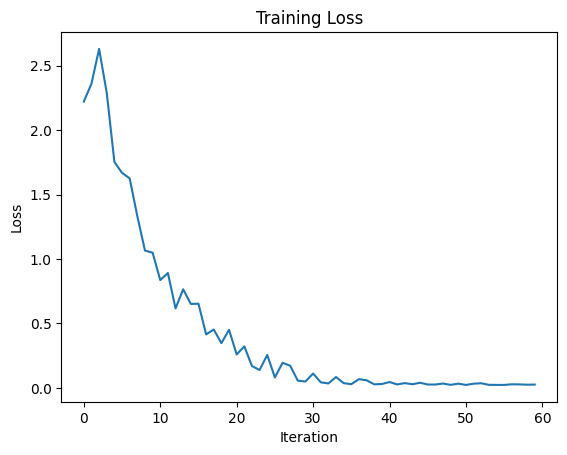

In [11]:
import matplotlib.pyplot as plt

loss_values = trainer.state.log_history

loss_values = [entry['loss'] for entry in loss_values if 'loss' in entry]

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [39]:
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    klaris_prompt.format(
        "bagaimana sistem penomoran mata kuliah?", # instruction
        "", # input
        "", # output
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128, temperature=0.5)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
bagaimana sistem penomoran mata kuliah?

### Input:


### Response:
sistem penomoran mata kuliah: 000-099 matakuliah prasyarat, 100-199 matakuliah tahun I, 200-299 matakuliah tahun II, 300-399 matakuliah tahun III, 400-499 matakuliah tahun IV, 500-599 matakuliah tahun V (profesi), 600-699 matakuliah tahun VI (pascasarjana)<|end_of_text|>


In [ ]:
model.push_to_hub("unklab1.0/unklab_model", token = "hf_token")
tokenizer.push_to_hub("unklab1.0/unklab_model", token = "hf_token")